# Importing data

In [1]:
import pandas as pd

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

In [4]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

# Creating a directed multigraph

In [5]:
import networkx as nx

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [7]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [8]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

#Due to some routes having an invalid source/destination, due to the airport not existing
#in the airport database, these routes are removed.
edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes]

airport_routes_digraph.add_edges_from(edges);

# Plotting the graph

In [9]:
import matplotlib.pyplot as plt

In [10]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [11]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    


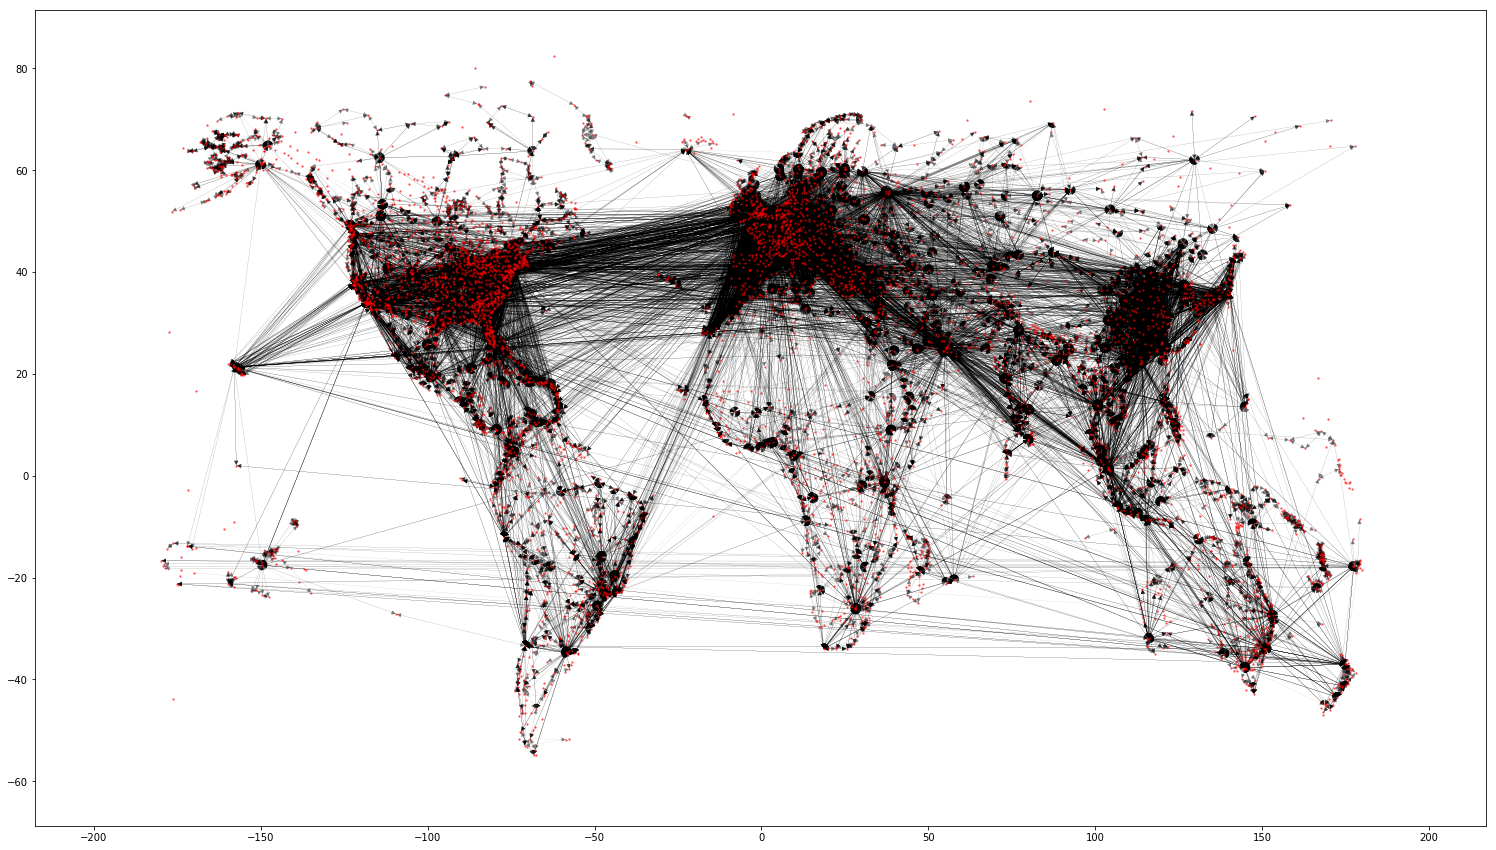

In [12]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph.png", transparent=True, bbox_inches='tight')

In [13]:
len(airport_routes_digraph.nodes)

5634

In [14]:
len(airport_routes_digraph.edges)

65836

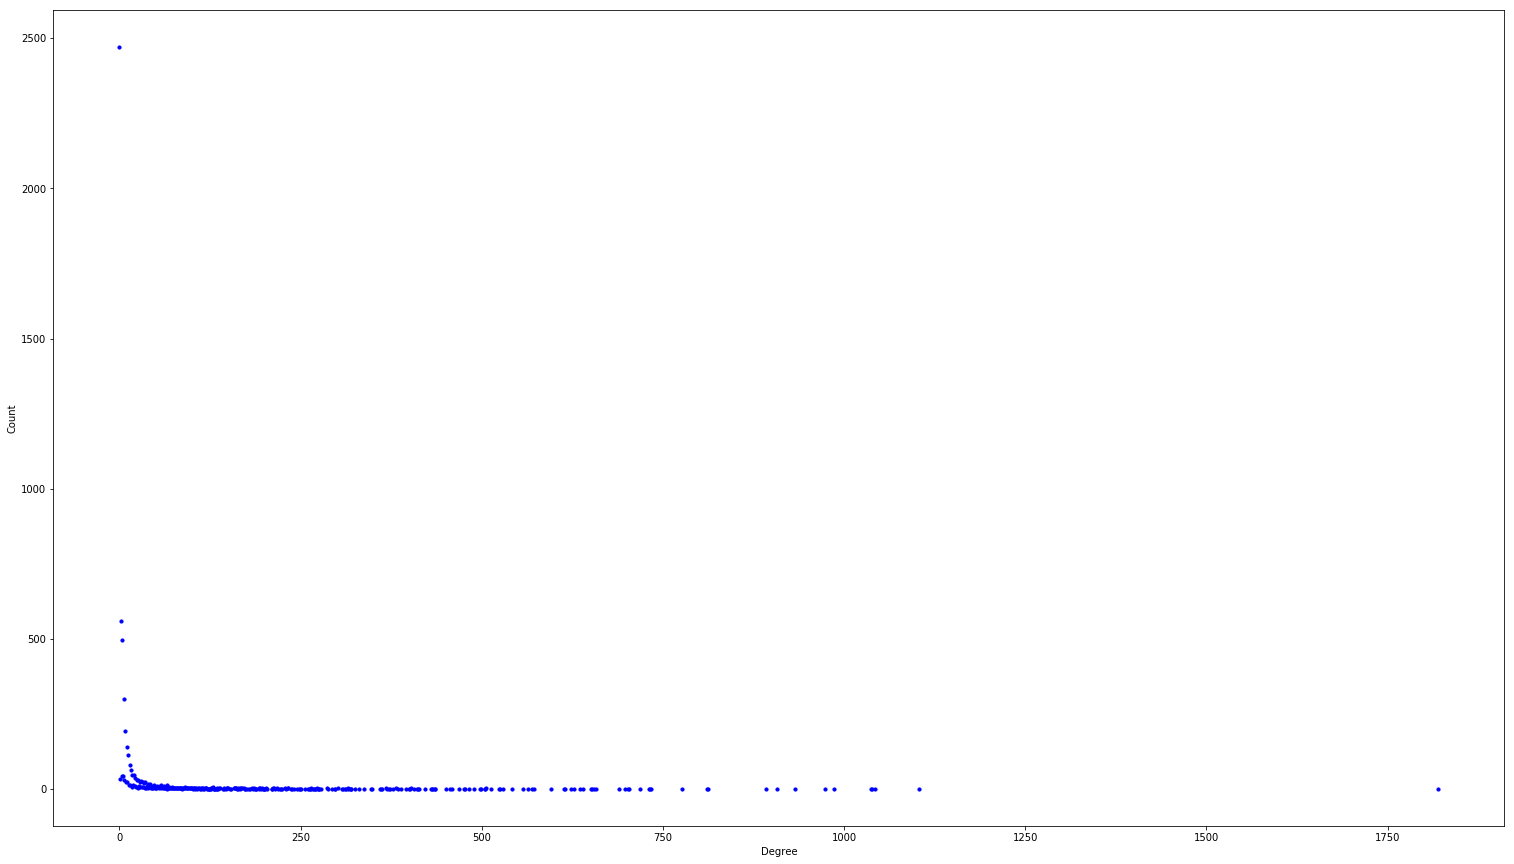

In [15]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/regularplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

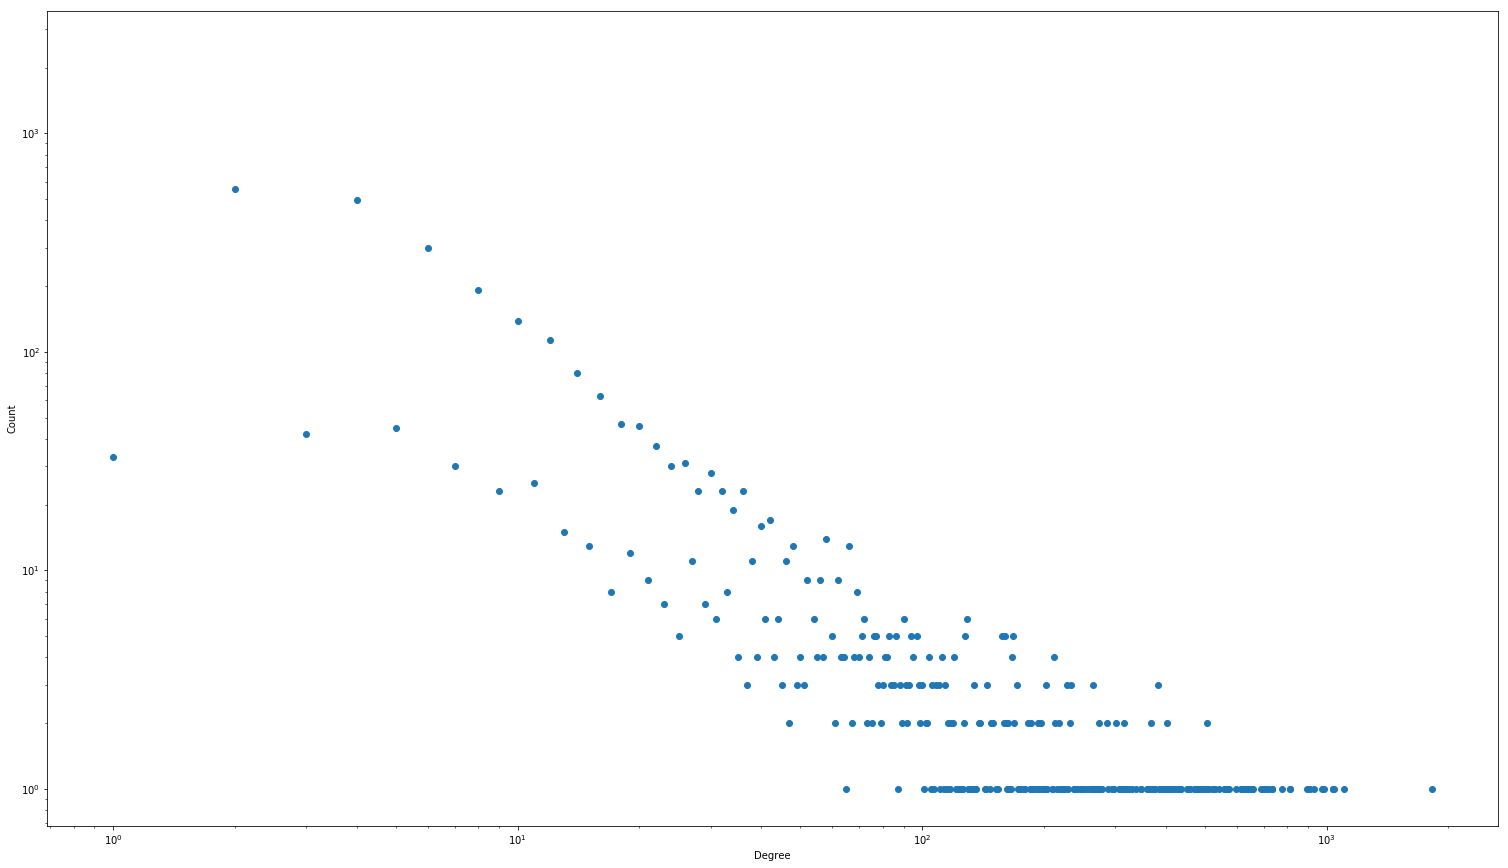

In [16]:
plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/powerlawplot.png', bbox_inches='tight')

# Community Detection

**Best Community Partition**

In [17]:
import community
from collections import Counter

In [18]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

In [19]:
print(community.modularity(community_partition,airport_routes_digraph.to_undirected()))

0.261486532742


In [20]:
countercoms = Counter(community_partition.values())
print("Top ten biggest communities out of " + str(len(community_partition)) + " communities:")
print(sorted(countercoms.values()))[-10:]

Top ten biggest communities out of 5634 communities:
[28, 130, 143, 163, 192, 288, 374, 417, 585, 732]


As we can see, the best community partition is a rather random one, which consists of a few communities containing many airports, but many communities with few airports. 
It would make sense that many of the larger airports that are interconnected would share the same community, e.g. many of larger airports in Europe and North America, as it can be seen from the plots that Europe and North America are especially well connected. It could also make sense that perhaps less connected areas in Afria and South America could create their own community, but it seems to be the case that some of the airports of less connected areas join the larger communities by just having a very few amount of connections to these highly connected areas, e.g. Europe.

The modularity for the best partition is 0.26, which is postive, but still sub-optimal. Considering that most airports are likely to be connected to another well connected airport, if it isn't well connected itself, it makes sense that the modularity isn't very high.

In [21]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

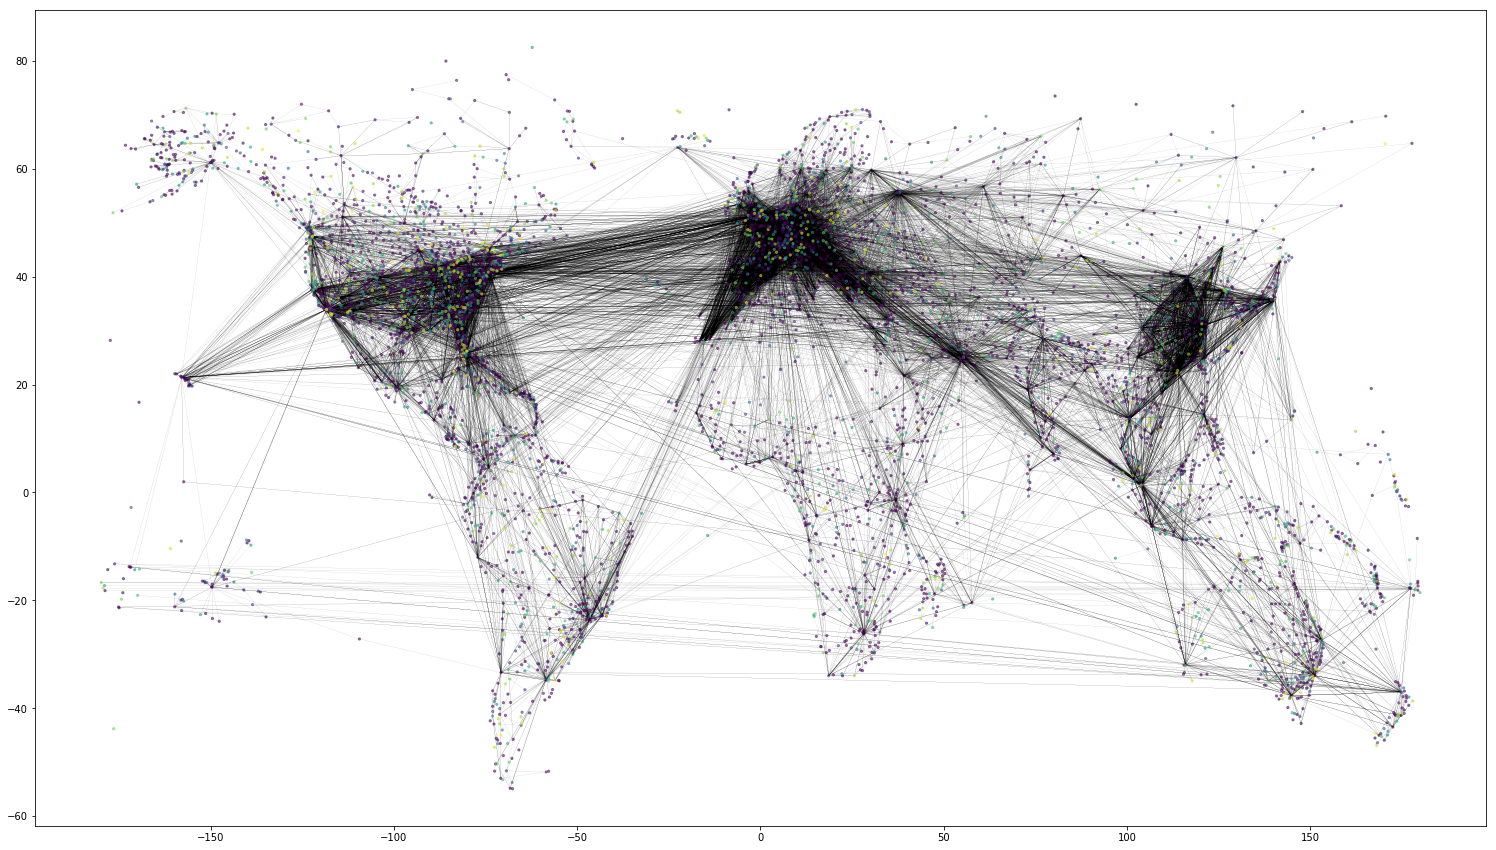

In [22]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=5,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_communities.png", transparent=True, bbox_inches='tight')

## Communities by Continent

**Preparing the data**

In [23]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [24]:
countriescontinents_df.set_index(['Country','Continent']);

In [25]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [26]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [27]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [28]:
def calculateLC(graph,community_df):
    lc = 0
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


**Calculating modularity**

In [29]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) + Mc(airport_routes_digraph,oce_df) + Mc(airport_routes_digraph,afr_df) + Mc(airport_routes_digraph,asia_df) + Mc(airport_routes_digraph,na_df) + Mc(airport_routes_digraph,sa_df)

In [30]:
modularity 

0.23643599246612798

**Commenting on modularity**

When dividing the different continents into different communities, a modularity that is almost as high as the optimal community partition modularity. Even though the modularity is not very high, i.e. sub-optimal, it is positive that using continents as communities is close to the best possible community partition. 

It would make sense that partitioning by continent would create a sub-optimal community partition. Continents tend to have a fair amount of flights going within the continent, due to the physical size of the continents. This is also visible in the various plots. There are however still many intercontinental flights, which heavily lowers the modularity which is also why it is hard to find a good community partition. The different airports around the world are simply very well interconnected.

**Community plot**

In [31]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

KeyboardInterrupt: 

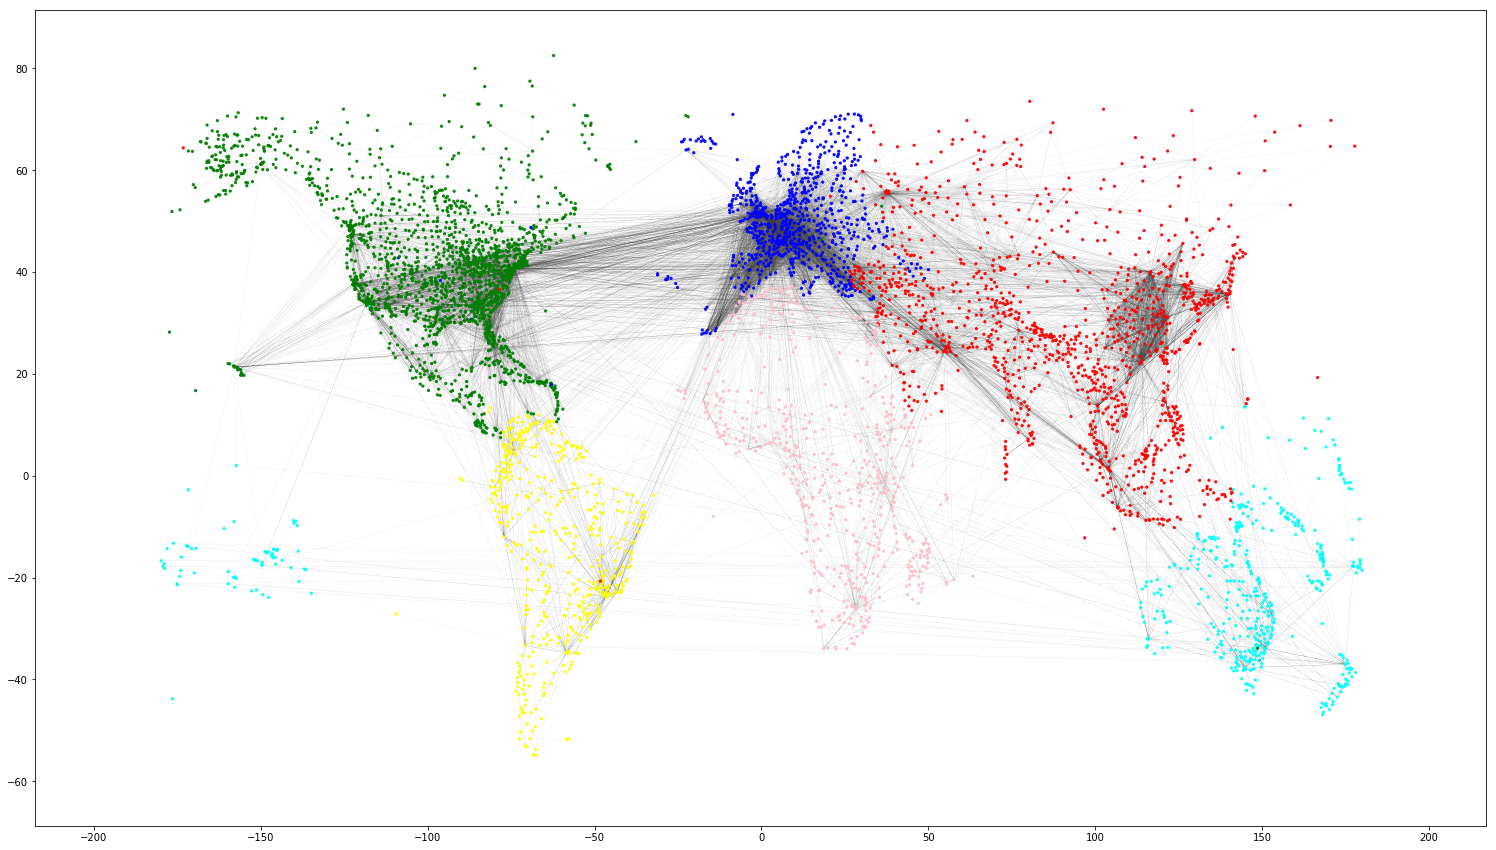

In [32]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_continent_communities.png", transparent=True, bbox_inches='tight')

# Communities by Countries

**Calculating modularity**

In [ ]:
countries = list(airports_df.groupby('Country').groups)

In [ ]:
country_dfs = []

In [ ]:
for country in countries:
    country_dfs.append((country,list(airports_df.loc[airports_df['Country'] == country].groupby('IATA').groups)))

In [ ]:
country_by_modularity =  [(c[0],Mc(airport_routes_digraph,c[1])) for c in country_dfs]
country_com_modularity = sum([Mc(airport_routes_digraph,c[1]) for c in country_dfs])

In [ ]:
print(country_com_modularity)

In [ ]:
countries_sort_by_mod = sorted(country_by_modularity,key = lambda (k,v):(v,k),reverse=True)
top_10_country_mod = countries_sort_by_mod[:10]
bot_10_country_mod = countries_sort_by_mod[-10:]

print("Top 10:")
print(top_10_country_mod)
print(" ")
print("Bottom 10:")
print(bot_10_country_mod)

**Commenting on modularity**

The modularity when creating communities based on countries is very low. This makes sense, since most countries are not very big and do not have a lot of domestic flights. Therefore many of outgoing flights from those countries are international. The bigger countries should be more ideal as a community, since their vast area would imply more domestic flights, but there aren't that many very large countries and  they too have large international airports connecting the country to other contintents. This is also exactly what can be noted by looking at the top 10 and bottom 10 countries by their contribution to the modularity of the whole community. The bottom 10 are smaller countries, and in many cases small islands, which further proves the above statement.

**Community plot**

In [ ]:
countrylabels = []
for node in airport_routes_digraph.nodes():
    countrylabels.append(countries.index(list(airports_df.loc[airports_df['IATA'] == node]['Country'])[0]))

In [ ]:
colors = list(map(plt.cm.get_cmap('hsv', len(set(countries))+1),countrylabels))

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = colors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_country_communities.png", transparent=True, bbox_inches='tight')

# Further Community Analysis

It was chosen also to analyze, whether hub airports tend to connect communities together. Here we're keeping the community partition using continents in mind, since it makes more sense to analyze that partition, than the best partition which at a quick glance is nonsensical.

In [ ]:
#The following hubs are found based on degree.
hubs = ['Hartsfield Jackson Atlanta International Airport',"Chicago O'Hare International Airport",
        'Beijing Capital International Airport','Charles de Gaulle International Airport',
        'London Heathrow Airport','Los Angeles International Airport',
        'Frankfurt am Main International Airport','Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport','John F Kennedy International Airport']

In [ ]:
nodesizes = []
nodeColors = []

#Hubs are colored xxx and a given a larger size than the remaining airports.
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    if (list(airports_df.loc[airports_df['IATA'] == node]['Name'])[0] in hubs):
            nodeColors.append('red')
            nodesizes.append(100)
    else:        
        nodesizes.append(2)
        if continent == 'Asia':
            nodeColors.append('purple')
        elif continent == 'Europe':
            nodeColors.append('blue')
        elif continent == 'Oceania':
            nodeColors.append('cyan')
        elif continent == 'Africa':
            nodeColors.append('pink')
        elif continent == 'North America':
            nodeColors.append('green')
        elif continent == 'South America':
            nodeColors.append('yellow')    
        else:
            nodeColors.append('brown')

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.9,node_color=nodeColors,node_size=nodesizes,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_with_high_degree_hubs.png", transparent=True, bbox_inches='tight')

Considering the plot above, the red plots are the hubs that were defined. What could be considered is whether or not the hubs tend to be links between communities. This has to be the case. Due to the fact that a given node is a hub, must also indicate that this node will be connected communities together. It could be the case that the hub only connects with other nodes in the same community. However, in this case we're dealing with airports and when using continents as a partioning, it will lead to the hubs connecting communities together.

## Cleaning up, making the graph weakly connected

In order to find the shortest paths, the graph had to be weakly connected, i.e. removing subraphs which are completly unconnected with the rest of the graph, keeping the largest connected subgraph. Since the original graph was not weakly connected, the NetworkX function *average_shortest_path_length* could not run, as this requires that a directed graph is weakly connected (Completly connected for undirected graphs).

In [ ]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from(edges);

# Average shortest path 

Here the largest connected sub graph is found using the function *connected_component_subgraphs* function of NetworkX. To get a sense of the size differences between the largest subgraph and the full, unconnected graph, the size of the two graph are printed.

In [ ]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected) # Find connected component subgraphs

print "Edges in graph: " + str(airport_undirected.number_of_edges())
print "Nodes in graph: " +  str(airport_undirected.number_of_nodes())
big_subgraph = max(subgraphs,key=lambda x: x.number_of_edges()) # Find the largest subgraph

print
print "Edges in subgraph: " + str(big_subgraph.number_of_edges())
print "Nodes in subgraph: " +  str(big_subgraph.number_of_nodes())

As it is observed the largest sub graph is not much smaller than the original, unconnected graph. Keep in mind the reason that there are far fewer edges it because the sub graph is undirected without duplicate edges. When the undirected version of the original, directed, graph, *airport_undirected*, is made it does not remove the duplicate edges, which are a result of converting a directed graph to undirected.

With the new largest sub graph, the average shortest path is found using *average_shortest_path_length* of NetworkX is used on the large sub graph.

In [ ]:

print "The average shortest path through out our network is: " + str(nx.average_shortest_path_length(big_subgraph))

With the average shortest path of 4, it indicates how few flights are required to travel to the other side of the planet. It also shows that most trips requires a few extra flights to reach an international airport, when flying between smaller airports.

# Longest Shortest Path

The first step in finding the longest shortest path is done here with the use of the function *shortest_path_length* of NetworkX. This function returns a list of tuples. These tuples contains firstly a source-node, and secondly a dictionary, containing target-nodes as keys and the length of the shortest path from the source-node to the target-node. 

The Python list comprehension shown in the code cell below makes a list of tuples only containing target-node which is the furthest away from any given source-node. Only the ten longest shortest paths are saved.

In [ ]:
shortest_path_lengths = sorted([(k, max(zip(v.values(), v.keys()))) for k,v in nx.shortest_path_length(big_subgraph)],key=lambda x: x[1][0],reverse=True)[:10]

### The shortest paths

In order to actually see the longest shortest paths, the next code cell fetches the 10 actual shortest paths, using the *shortest_path* function of NetworkX.

In [ ]:
paths = []
for item in shortest_path_lengths:
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

The first element of this list of shortest paths will thus be the longest throughout the aviation network, which in the following is printed:

In [ ]:
print paths[0]
for p in paths[0]:
    print airports_by_iata_df.get_group(p).iloc[0]['Name']

In [ ]:
print len(paths[0])

A trip that requires one to fly from the outskirts of Australia to the outskirts of Canada, a flight between quite alot of smaller airports. Especially in Canada, where the trip requires one to fly in between lots of small airports, with very short trips in between, results in a trip with alot of connecting flights. In fact; once the airplane has landed at Lester B. Pearson International Airport the rest of the trip takes place in Canada, which is more than half of the airports included in the shortest path!

The next code cell finds the paths used in this shortest path, so that it can be visualized

In [ ]:
longest_path_edges = []
for i in range(0,len(paths[0])-1):
    longest_path_edges.append((paths[0][i],paths[0][i+1]))

In [ ]:

options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

The following plot shows the original plot of the aviation graph, but the longest shortest path is colored red, so that one can try to see how the trip traverses the globe.

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=longest_path_edges, width = 2, alpha = 1, edge_color='r')
plt.axis('off')
fig.show()

Here the longest trip, in terms of number of airports, can be seen. 12 connecting flights

In [ ]:
fig.savefig("output/longest_shortest_path.png",transparent=True, bbox_inches='tight')

## Node size in terms of node degree

To visualize the node degrees, the aviation graph is plotted with the node sizes depending on the node degrees.

In [ ]:
d = dict(nx.degree(big_subgraph))

In [ ]:
fig_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_degree.show()

With many flight routes across the Atlantic, it is not very surprising that lots of the airports in Europe and the Americas have rather high degrees. With so many airports in Europe, it is hard to detect specific airports with high degree. On the west coast of the US, it is possible to detect LAX (Los Angeles International Airport), a very large airport which have many international flights to Europe and national flights around the US.

In [ ]:
fig_degree.savefig("output/graph_degree_size.png",transparent=True, bbox_inches='tight')

## Node size in terms of betweenness centrality
To get a sense of which airports are most often used for connecting flights, the network is plotted with the node sizes determined by the betweenness centrality measure. It is assumed that the nodes with higher betweenness centrality will be the larger international airports.

In [ ]:
bc = nx.betweenness_centrality(big_subgraph)
fig_betweeness = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_betweeness.show()

Here we see the graph, plotting the nodes' sizes in terms of there betweenness centrality. Here LAX is visible again, more clearly, and it also shows lots of the european airports have high betweeness centrality. Interestingly, one airport in Alaska have a rather high betweenness centrality, which one would think is because this airport connects the rest of the smaller Alaskan airports to the rest of the world. There are also a few airports over in the east (China, Japan and Australia) which stand alone with a rather high betweenness centrality. This indicates that these airports connects there respective areas to the rest of the world.

In [ ]:
fig_betweeness.savefig("output/graph_betweeness_centrality.png",transparent=True, bbox_inches='tight')

## Node size in terms of eigenvector centrality

To get a sense of how compactly the nodes are connected the network is plotted with the node sizes being determined by the nodes' eigenvector centrality measures. This will also determine how closely connected the small nodes out in the middle of nowhere are to the larger hubs of the network.

In [ ]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
fig_eigen = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 3000 for v in ec.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_eigen.show()

The eigenvector centralities lightens up the world, making the nodes brighten up. This indicates that the world's airports are very connected, easily giving lots of the different airports high scores in terms of eigenvector centrality. Notably, some airports throughout Africa and Oceania are closely connected, giving them higher eigenvector centralities.

In [ ]:
fig_eigen.savefig("output/graph_eigenvector_centrality.png",transparent=True, bbox_inches='tight')

## Airports with the most connections (highest degree)
To get a view of the airports with the highest degrees, ie get an understanding of which airports are most connected, the top 10 airports in terms of degree is listed below.

In [ ]:
top_airports_degree = sorted(d.iteritems(),key = lambda (k,v):(v,k),reverse=True)[:10]
for ai,de in top_airports_degree:
    print "Airport: " +  airports_by_iata_df.get_group(ai).iloc[0]['Name'] ", Degree: " + str(de)

By far the airport with the highest degree is Hartsfield Jackson Atlanta International Airport, an international airport used heavily for especially connecting airports in the southern US to the rest of the world. Other interesting airports are London Heathrow Airport and Charles de Gaulle International Airport which are two very large airports in Europe connecting the continent to the rest of the world and Beijing Capital International Airport a very central airport in Asia.

## Airports with the highest betweeness centrality

To get a better understanding of which airports are most relevant in shortest paths, the 10 airports with highest betweenness centralities are listed.

In [ ]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], be)

Besides the more famous and busy international airports, which also was present in the airports with highest degree, one can also see the outlier of Ted Stevens Anchorage International Airport. This airport, as mentioned before is placed in Alaska, and has the task of connecting many of the Alaskan airports to the rest of the world, resulting in this airport having a large betweenness centrality.

## Airports with the highest eigenvector centralities
To get an understanding of how closely connected the larger airports are connected, the top 10 airports in terms of egenvector centralities are listed.

In [ ]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], ee)

This shows that the airports with highest eigenvector centralities are all placed in Europe, where all airports are closely connected, greatly increasing all of their eigenvector centralities, as they all effect eachother.

# Analysis of graph i terms of sentiment
Next a connection between the Twitter sentiment analysis and the aviation graph needs to be drawn. It could for instance be nice to try and visualize with the graph which airports have different sentiments.

Firstly, the calculated sentiments needs to be prepared for the visualization.

In [2]:
# Dictionary to quickly lookup the airports' IATA code given a name.
Airport_Name_IATA = {}
for _,row in airports_df.iterrows():
    Airport_Name_IATA[row['Name']] = row['IATA']

NameError: name 'airports_df' is not defined

In [ ]:
import unicodecsv as csv
import codecs

sentiment_dict= {} # Dictionary to lookup the airports' twitter sentiment given a IATA code.
with open("output/airport_sentiment.csv") as csv_file:
    csv_reader = csv.reader(csv_file,delimiter='\t',encoding='utf-8')
    linecount = 0
    for row in csv_reader:         
        
        if linecount != 0 and row[0] in Airport_Name_IATA:
            iata = Airport_Name_IATA[row[0]]
            if iata in big_subgraph.nodes():
                sentiment_dict[iata] = float(row[1])
        linecount += 1
        

In [ ]:
# Sentiment variables used for colormap
sentiment_mean = mean(sentiment_dict.values())
sentiment_min = min(sentiment_dict.values())
sentiment_max = max(sentiment_dict.values())
print sentiment_mean
print sentiment_min
print sentiment_max

In [ ]:
color_map = [] # Color map used to determine colors depending on sentiment
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

for n in sentiment_dict.values():
    if n <= sentiment_mean:
        color_map.append(convert_to_hex([1,(sentiment_mean-sentiment_min)-(sentiment_mean-n),(sentiment_mean-sentiment_min)-(sentiment_mean-n)]))
    else:
        color_map.append(convert_to_hex([(sentiment_max-sentiment_mean)-(n-sentiment_mean),1,(sentiment_max-sentiment_mean)-(n-sentiment_mean)]))

## Absolute sentiment
Firstly the aviation graph is shown, with the node size being determined by how much the twitter sentiment deviates from the mean sentiment. Airports with positive sentiment are colored green and airports with negative sentiment are colored red. The darkness of a node's color is also determined by how much the airport's twitter sentiment deviates from the mean sentiment.

In [ ]:
fig_absolute = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 3000**abs(v - sentiment_mean) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute.show()

It seem that the airports with the most negative sentiment is around Madagascar and in northern Europe, and the airports with most positive twitter sentiment seems to be in the Middle East.

In [ ]:
fig_absolute.savefig("output/graph_absolute_sentiment.png",transparent=True, bbox_inches='tight')

## Most positive airports
To focus on the airports with positive sentiment, the next plot has the node sized be determined by how positive the twitter sentiment is.

In [ ]:
fig_positive = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 100**(v - sentiment_min) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive.show()

It seems that the airports with the highest sentiment is placed in the Middle East. This could because of the large economies which have financed these airports, focusing greatly on luxury. More over, airports in Alaska also seem to have a high sentiment.

In [ ]:
fig_positive.savefig("output/graph_positive_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Most negative airports
To focus on the airports with negative sentiment, the next plot has the node sized be determined by how negative the twitter sentiment is.

In [ ]:
fig_negative = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 150**(sentiment_max - v) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative.show()

Here we see that alot of the airports in nothern and southern Europe have very low sentiments and joining them are a few airports off the coast of Africa.

In [ ]:
fig_negative.savefig("output/graph_negative_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. high degree
Next it could be interesting to find if there is a relation between an airport's twitter sentiment and how busy it is, ie the node degree. Firstly the sentiment is compared to the higher degrees.

In [ ]:
max_degree = max(d.values())

In [ ]:
fig_absolute_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500*((abs(v - sentiment_mean)/d[k]**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_degree.show()

Unfortunatly it does not seem like there are any airport, either positive or negative, which stands out. For this reason one cannot say for certain that there is any relation between sentiment and how busy the airport is.

In [ ]:
fig_absolute_degree.savefig("output/graph_absolute_sentiment_degree.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs low degree
Likewise it could be interesting to see if there are any relation between having a low degree and a strong absolute sentiment.

In [1]:
fig_absolute_mindegree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 5000*((abs(v - sentiment_mean)/(max_degree-d[k]+1)**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_mindegree.show()

NameError: name 'plt' is not defined

The only airport standing out is the airport which by far has the largest degree, so for this reason nothing can be concluded from this relation.

In [ ]:
fig_absolute_mindegree.savefig("output/graph_absolute_sentiment_min_degree.png",transparent=True, bbox_inches='tight')

## Positive airports with high degree

In [ ]:
fig_positive_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((v - sentiment_min))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive_degree.show()

In [ ]:
fig_positive_degree.savefig("output/graph_positive_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Negative airports with high degree

In [ ]:
fig_negative_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((sentiment_max - v))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative_degree.show()

In [ ]:
fig_negative_degree.savefig("output/graph_negative_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. lattitude and longitude

As it did not seem that there were any relation between node degree and twitter sentiment, it is interesting to see if there could be a relation between the twitter sentiment and the airports' geographical positions, in terms of the lattitude degrees and longitude degrees. The relation will firstly be checked for the lattitude degrees and afterwards with the longitude. There will not be checked for any relation with the two degrees in conjunction. 

In [ ]:
# Making two dictionaries so that it will be easy to look up a airport's longitude and lattitude by the IATA code.
airport_iata_latitude = {}
airport_iata_longitude = {}
for _,row in airports_df.iterrows():
    airport_iata_latitude[row['IATA']] = row['Latitude']
    airport_iata_longitude[row['IATA']] = row['Longitude']

### Near the equator

Firstly it will be seen if there is a relation between having an airport closer to the equator will have any influence on the twitter sentiment.

In [ ]:
fig_absolute_latitude_equator = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((90-abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_equator.show()

From the plot it does not look like there is a visible relation between an airport's lattitude degree and its twitter sentiment.

In [ ]:
fig_absolute_latitude_equator.savefig("output/graph_absolute_latitude_equator.png",transparent=True, bbox_inches='tight')

### Near the poles
Like wise it will be seen if there is a relation between being closer to the poles and the twitter sentiment.

In [ ]:
fig_absolute_latitude_poles = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2.5)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_poles.show()

Again, it does not look like there is any relation between the lattitude and twitter sentiment.

In [ ]:
fig_absolute_latitude_poles.savefig("output/graph_absolute_latitude_poles.png",transparent=True, bbox_inches='tight')

### Middle longitude
There could possibly be a connection between being closer to 0 longitude degree than being far to the west or east. This will be checked here, comparing the longitude degree and the twitter sentiment analysis.

In [ ]:
fig_absolute_longitude_zero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((180-abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_zero.show()

Coincidentally, it would seem that the airports with the higher absolute sentiments are closer to 0 lattitude degree. But again this does not really say anything about how it affects the sentiment to be more positive or negative.

In [ ]:
fig_absolute_longitude_zero.savefig("output/graph_absolute_longitude_zero.png",transparent=True, bbox_inches='tight')

### Being in the far east or far west
Finally it will be seen if there is any relation between being placed far in the east or far in the west and if it has an affect on the airport's twitter sentiment.

In [ ]:
fig_absolute_longitude_nonzero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_nonzero.show()

It does not seem like there is a relation here either.

In [ ]:
fig_absolute_longitude_nonzero.savefig("output/fig_absolute_longitude_nonzero.png",transparent=True, bbox_inches='tight')

So, it does not seem like there are any relation between the found Twitter sentiment and the aviation graph analysis. This is very much possible, as discussed previsously, the airports with more positive twitter sentiment is located in the Middle East, areas in which the economy is going really well, where tons of money and finances are spend on culture of luxury. This means that the twitter sentiment could possibly not depend on the geographical position of the airport, or how busy it is. Seeing as how airports like Dubai International Airport have positive sentiment, one tends to believe that it could possibly just depend on how much the airport takes care of its travelers and how luxurious the airport is. 

More over, using the Twitter sentiment as a measure of how nice an airport is not really a very good measure, as most of the tweets being posted in airports are posted by staff members as public service anouncements are advertising for special deals or events. These types of tweets tends to be far more positive or at least neutral

# Tweets sentiment

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
from PIL import Image
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [ ]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [ ]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

In [ ]:
airports

## TF-IDF analysis of Twitter

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.

In [ ]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopworld, punctuation, and blacklisted words, such as keywords used by twitter.

In [ ]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [ ]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

In [ ]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each of the words occure in takes some time, we have cheated a little and saved the result. To optimize the calculations, we have transformed each of the documents into sets.

In [ ]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [ ]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the IDF can now be done using the following function.

In [ ]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

In [ ]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in tqdm(list(airports['Name']))
}

Calculate the TF_IDF

In [ ]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [ ]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

In [ ]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

The most used words in all of the documents:

In [ ]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [ ]:
freqency_total = FreqDist(all_tokens)

## Word clouds

In [ ]:
def drawWordCloud(text: str, title: str, mask: str = None):
    if mask:
        mask = np.array(Image.open(os.path.join('masks', mask)))
        
    wordcloud = WordCloud(
        collocations=False,
        mask=mask,
#         background_color='white',
        contour_width=3, 
        contour_color='steelblue'
        ).generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
#     ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    imageio.imwrite(f'output/{title}.png', np.array(wordcloud))
    plt.show()

In [ ]:
combined_all_tokens = ' '.join(all_tokens)

In [ ]:
drawWordCloud(combined_all_tokens, 'All tokens', 'Airplane_silhouette.png')

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [ ]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')

We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.

In [ ]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

In [ ]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

In [ ]:
tweets_list = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

In [ ]:
tweets_tokenized = { 
    airport: [tokenize(tweet) for tweet in ts]
    for airport, ts in tweets_list.items()
}

In [ ]:
sentiment = {
    airport: [calculate_sentiment(tweet, h_avg) for tweet in ts]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [ ]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

Plot the distribution of the sentiment in all of the tweets.

In [ ]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

In [ ]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

In [ ]:
mean = np.mean(sentiment_all)
std = np.std(sentiment_all)
print('Sentiment mean and standard deviation of all the tweets. Mean: {0:f} sigma: {1:f}'
      .format(mean, std))

Analysis tweets based on sentiment

In [ ]:
negative_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean - 2*std]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in negative_tweets.values() for t in ts]), 
      'Negative tweets', 'Airplane_silhouette.png')

When looking at the words most used in the negative tweets, we see that they are a lot of account names are used, such official airport accounts.
The word *queue* can also be found in here, which is to be expected.

Looking at words in the positive tweets

In [ ]:
positive_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean + 2*std]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in positive_tweets.values() for t in ts]), 
      'Positive tweets', 'Airplane_silhouette.png')

For the positive tweets, we see words such as *office*, which would point to many people are enjoying working from the airport.
Words like *bar*, *resturant*, and *nightclub* are also found, poniting to that most people enjoy being at these places.

## The least and most liked airports in the world

In [ ]:
sentiment_avg = {
    airport: np.mean(values)
    for airport, values in sentiment.items()
}

In [ ]:
sorted_sentiment = sorted(sentiment_avg.items(), key=lambda x: x[1])

In [ ]:
def showAirportScore(airport: str):
    print(f'{airport}'.ljust(50), f'{sentiment_avg[airport]}')

First we can find the mean and standard deviation of the sentiment of the airports.

In [ ]:
print('Mean and standard deviation sentiment of the airports: mean: {0:f}, sigma: {1:f}'
     .format(np.mean(list(sentiment_avg.values())), np.std(list(sentiment_avg.values()))))

Now we can find the top five least and most liked airports in the world.

In [ ]:
print('The least liked airports in the world')
for airport, _ in sorted_sentiment[:5]:
    showAirportScore(airport)

In [ ]:
print('The most liked airports in the world')
for airport, _ in sorted_sentiment[::-1][:5]:
    showAirportScore(airport)

In [ ]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [ ]:
for airport in busiest_airports:
    showAirportScore(airport)

In the output above, it can be seen that most of the busiest airports in the world is close to the average of all of the airports in the world, however all of them is slightly below.
London Heathrow Airport and Tokyo Haneda International Airport are quite low on the list, while Dubai International Airport is most more liked than all of the other busy airports.

## Exporting results

In [ ]:
import csv

In [ ]:
with open('./output/airport_sentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(('Airport', 'Sentiment'))
    for row in sorted_sentiment:
        writer.writerow(row)

In [ ]:
with open('./output/sentiment_all.txt', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_all):
        if value < 10 and value != 0:
            f.write(str(value) + '\n')